In [58]:
using DifferentialEquations
using Distributions
using StatsBase
using LinearAlgebra
using LsqFit
using PyPlot; const plt = PyPlot
PyPlot.matplotlib.style.use("./paper.mplstyle");

include("utils.jl")
include("kernels.jl")
include("block_delay_kernel_dde.jl")
include("erlang_superpos_kernel.jl")
include("erlang_block_kernel.jl");
include("erlang_two_step_kernel.jl")

erlang_two_step_kernel_fp (generic function with 1 method)

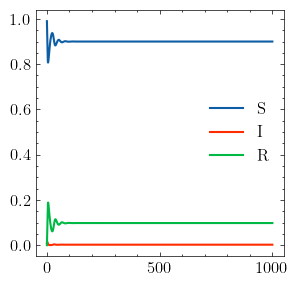

In [179]:
function sirs!(du, u, p, t)
    β, ρ, γ = p
    du[1] = - β * u[2] * u[1] + γ * u[3]
    du[2] = β * u[2] * u[1] - ρ * u[2]
    du[3] = ρ * u[2] - γ * u[3]
end

function solve_sirs(β, ρ, γ, I₀, t_max)
    p = (β, ρ, γ)
    u₀ = [1-I₀, I₀, 0]
    sol = solve(
        ODEProblem(sirs!, u₀, (0.0, t_max), p),
        RK4(),
        reltol = 1e-8
    )
    return sol
end

p = (β, ρ, γ) = (5, 4.5, 0.1)
I₀ = 0.01
t_max = 1000
sol = solve_sirs(p..., I₀, t_max)
fig, ax = plt.subplots()
# ax.set(xlim=(0, 100))
ax.plot(sol.t, sol[1, :], label = "S")
ax.plot(sol.t, sol[2, :], label = "I")
ax.plot(sol.t, sol[3, :], label = "R")
ax.legend()
display(fig)

# Kernels

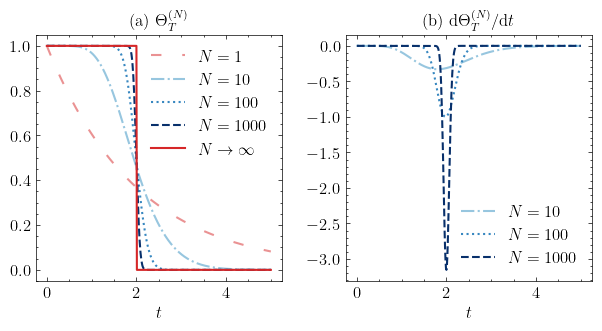

In [115]:
T = 2
τ_range = 0:0.01:2.5*T
fig, (axl, axr) = plt.subplots(nrows = 1, ncols = 2, figsize = (7.2, 3.2))
axl.plot(
    τ_range, Θ_ker.(τ_range, T, 1),
    label = L"N = 1", color = "tab:red", alpha = 0.5,
    linestyle = (0, (5, 10))
)
axl.plot(
    τ_range, Θ_ker.(τ_range, T, 10),
    label = L"N = 10", color = plt.get_cmap("Blues")(100),
    linestyle = "-."
)
axl.plot(
    τ_range, Θ_ker.(τ_range, T, 100),
    label = L"N = 100", color = plt.get_cmap("Blues")(170),
    linestyle = ":"
)
axl.plot(
    τ_range, Θ_ker.(τ_range, T, 1000),
    label = L"N = 1000", color = plt.get_cmap("Blues")(255),
    linestyle = "--"
)
axl.plot(
    τ_range, Θ.(τ_range, T),
    label = L"N \to \infty", color = "tab:red"
)
axl.legend()

axr.plot(
    τ_range, -Kₘ.(τ_range, T/10, 10)/T,
    label = L"N = 10", color = plt.get_cmap("Blues")(100),
    linestyle = "-."
)
axr.plot(
    τ_range, -Kₘ.(τ_range, T/100, 100)/T,
    label = L"N = 100", color = plt.get_cmap("Blues")(170),
    linestyle = ":"
)
axr.plot(
    τ_range, -Kₘ.(τ_range, T/1000, 1000)/T,
    label = L"N = 1000", color = plt.get_cmap("Blues")(255),
    linestyle = "--"
)
axr.legend()

axl.set(
    xlabel = L"t",
    box_aspect = 1,
    title = L"\text{(a) }\Theta_T^{(N)}"
)
axr.set(
    box_aspect = 1,
    xlabel = L"t",
    title = L"\text{(b) }\mathrm{d}{\Theta}_T^{(N)}/\mathrm{d}t"
    # title = L"\text{(b) }\mathrm{d}\Theta_T^{(N)} / \mathrm{d}\tau"
)
display(fig)
fig.savefig("./img/block-kernel.png", dpi=500)
fig.savefig("./img/block-kernel.svg", format="svg")

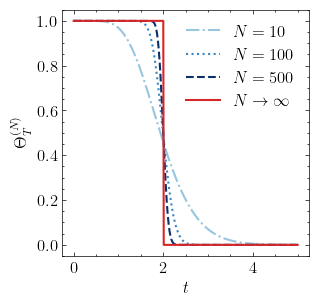

In [66]:
T = 2
τ_range = 0:0.01:2.5*T
fig, ax = plt.subplots(figsize=(3.2, 3.2))
ax.set(xlabel=L"t", ylabel=L"\Theta_T^{(N)}", box_aspect=1)
ax.plot(
    τ_range, Θ_ker.(τ_range, T, 10),
    label = L"N = 10", color = plt.get_cmap("Blues")(100),
    linestyle = "-."
)
ax.plot(
    τ_range, Θ_ker.(τ_range, T, 100),
    label = L"N = 100", color = plt.get_cmap("Blues")(170),
    linestyle = ":"
)
ax.plot(
    τ_range, Θ_ker.(τ_range, T, 500),
    label = L"N = 500", color = plt.get_cmap("Blues")(255),
    linestyle = "--"
)
ax.plot(
    τ_range, Θ.(τ_range, T),
    label = L"N \to \infty", color = "tab:red"
)
ax.plot(
    τ_range, Θ_ker.(τ_range, T, 1),
    label = L"N = 500", color = plt.get_cmap("Blues")(255),
    linestyle = "--"
)
ax.legend()
display(fig)

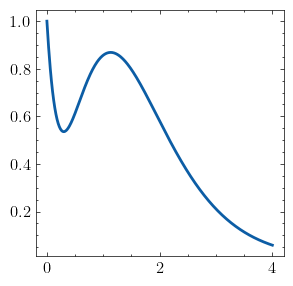

In [119]:
fig, ax = plt.subplots()
T = 2; N = 4
f(τ) = (Kₘ(τ, T/N, 1) - Kₘ(τ, T/N, 2) + 3 * Kₘ(τ, T/N, 3) + 1 * Kₘ(τ, T/N, 4)) * T / N
x = 0:0.01:2*T
ax.plot(x, f(x))
display(fig)

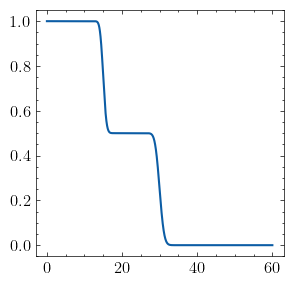

In [144]:
c(m) = m <= N/2 ? 1 : 0.5

fig, ax = plt.subplots()
T = 30; N = 1000
f(τ) = T / N * sum([c(m) * Kₘ(τ, T/N, m) for m in 1:N])
x = 0:0.01:2*T
ax.plot(x, f(x))
display(fig)

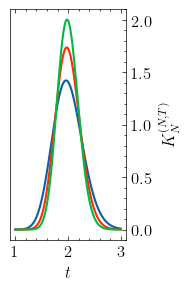

In [52]:
fig, ax = plt.subplots(figsize=(1.5,3))
ax.set(xlabel=L"t", ylabel=L"K_{N}^{(N,T)}")
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ts = 1:0.01:3; T = 2
for N in [50, 75, 100]#[end:-1:1]
    ax.plot(ts, Kₘ.(ts, T/N, N))
end
fig.savefig("./img/erlang-kernel.png", dpi=500)
display(fig)

# SIRS time delay system with step function block delay kernel (Hethcote et al. 1981)

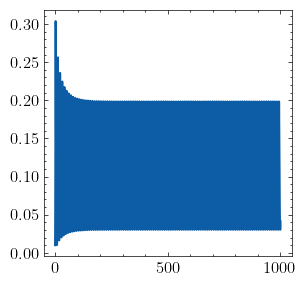

0.305244771656034
0.4926388580566674


In [11]:
p = (β, ρ, T) = (3, 1, 6)
I₀ = 0.01
t_max = 1000
sol = solve_step_function_kernel(p..., I₀, t_max)

println(pearson_skew(sol, 1, 200, t_max))
println(skew(sol, 1, 200, t_max))

fig, ax = plt.subplots()
# ax.set(xlim=(0, 200))
ax.plot(sol.t, sol[1, :])
# ax.plot(sol.t, sol[2, :])
display(fig)

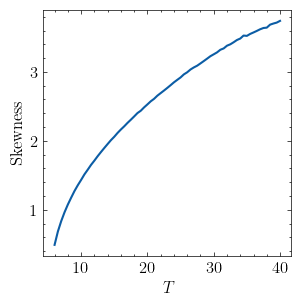

In [19]:
β, ρ = 3, 1
I₀ = 0.01
t_trans = 200; t_max = 5000

# X
Ts = 6:0.5:40
# Y
skews = [skew(solve_step_function_kernel(β, ρ, T, I₀, t_max), 1, t_trans, t_max) for T in Ts]

fig, ax = plt.subplots()
ax.set(xlabel = L"T", ylabel = "Skewness")
ax.plot(Ts, skews)
display(fig)

# Block delay kernel as Erlang Kernel sum

The dwell-time of individuals in the recovered compartment R is given by a block
kernel. With that the recovered compartment is given as a superposition
$$
    R = \sum_m R_m
$$

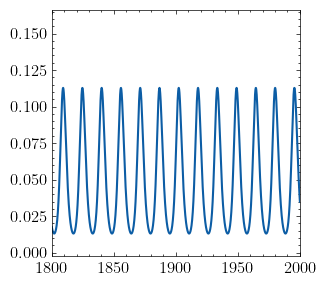

In [41]:
p = (β, ρ, T, N) = (2, 1, 9, 200)
I₀ = 0.01
t_max = 2000
sol = solve_erlang_block_kernel(β, ρ, T, N, I₀, t_max)

# println(pearson_skew(sol, 1, 300, t_max))
# println(skew(sol, 1, 3000, t_max))

fig, ax = plt.subplots()
ax.set(xlim=(1800, 2000))
ax.plot(sol.t, sol[1, :])
# ax.plot(sol.t, erlang_sum_kernel_R(sol))
display(fig)

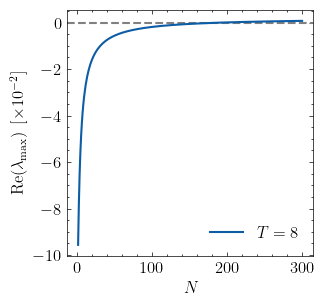

In [107]:
p = (2, 1, 8)
Ns = 2:300

fig, ax = plt.subplots()
ax.set(
    xlabel = L"N", ylabel = L"\operatorname{Re}(\lambda_\mathrm{max}) \: \left[\times 10^{-2}\right]",
    box_aspect = 1
)
ax.axhline(0.0, ls = "--", c = "gray")
ax.plot(Ns, λ_max.(erlang_block_kernel_jacobian.(p..., Ns)) ./ 10^(-2),
        label = L"T = %$(p[end])")
ax.legend()
display(fig)

In [118]:
function generate_skew_convergence(
        β::Real, ρ::Real, T::Real, N_max::Integer, t_trans::Real, t_max::Real;
        I₀ = 0.01
    )
    p = (β, ρ, T)
    N = N_onset = erlang_block_kernel_oscillation_onset(p...; N_max = N_max)
    dN = 1
    Ns = []
    while N <= N_max
        push!(Ns, N)
        N += dN
        dN += 1
    end
    skews = [skew(solve_erlang_block_kernel(p..., N, I₀, t_max), 1, t_trans, t_max; Δt = 0.01) for N in Ns]
    return Ns, skews
end;

# p = (β, ρ, T) = (2, 1, 16)
# I₀ = 0.01
# t_trans = 3000; t_max = 20000
# # Reference value -- step function kernel (sfk)
# skew_sfk = skew(solve_step_function_kernel(p..., I₀, t_max), 1, t_trans, t_max)
# # Increasingly sharp erlang sum kernels (esk)
# Ns, skews_esk = generate_skew_convergence(p..., 100, t_trans, t_max);

generate_skew_convergence (generic function with 1 method)

Skewness 1.135275086377799Skewness 0.9028046792527811Skewness 0.6703469297278891

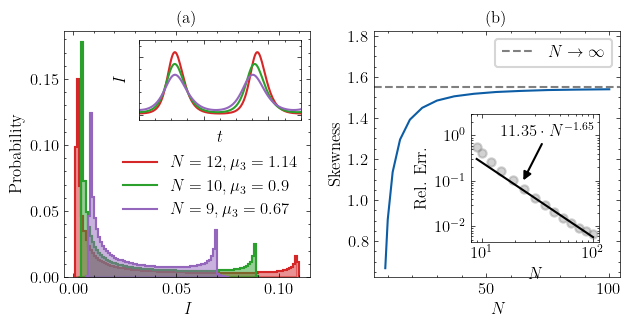

In [120]:
# parameters (β, ρ, T, N)
parameter_sets = [(2, 1, 16, 12), (2, 1, 16, 10), (2, 1, 16, 9)]
colors = ["tab:red", "tab:green", "tab:purple"]
t_shifts = [3, -11.6, -4.7]
I₀ = 0.01
t_max = 5000; t_trans = 300

fig, (axl, axr) = plt.subplots(ncols = 2, figsize=(7.2, 3.2))
axl.set(xlabel = L"I", ylabel = "Probability", box_aspect = 1, title = "(a)")
inax = fig.add_axes([0.23, 0.6, 0.225, 0.25])
inax.set(xlim=(4500, 4550), ylim=(-0.01, 0.13), xlabel=L"t", ylabel = L"I")
inax.xaxis.set_ticklabels([])
inax.yaxis.set_ticklabels([])
for (p, c, t_shift) in zip(parameter_sets, colors, t_shifts)
    sol = solve_erlang_block_kernel(p..., I₀, t_max)
    inax.plot(sol.t .- t_shift, sol[1, :], c = c)
    μ₃ = skew(sol, 1, t_trans, t_max)
    print("Skewness ", μ₃)
    # print("Pearson ", pearson_skew(sol, 1, t_trans, t_max))
    hist = normalized_sol_hist(sol, 1, t_trans, t_max)
    axl.stairs(hist.weights, hist.edges[1], color = c, label = L"N = %$(p[end]), \mu_3 = %$(round(μ₃, digits = 2))")
    axl.fill_between(hist.edges[1][1:end-1], hist.weights, alpha = 0.5, step = "post", color = c)
end
axl.legend(bbox_to_anchor=(0.18,0.18))

p = (2, 1, 16)
I₀ = 0.01
t_trans = 500; t_max = 20000; N_max = 100
axr.set(
    box_aspect = 1,
    # xscale = "log", yscale = "log",
    xlabel = L"N", ylabel = "Skewness",
    ylim = (0.625, 1.825),
    title = "(b)"
)
# Reference value -- step function kernel (sfk)
skew_sfk = skew(solve_step_function_kernel(p..., I₀, t_max), 1, t_trans, t_max)
axr.axhline(skew_sfk, ls = "--", c = "gray", label = L"N \to \infty")
# Increasingly sharp erlang sum kernels (esk)
Ns, skews_esk = generate_skew_convergence(p..., N_max, t_trans, t_max);
axr.plot(Ns, skews_esk)
axr.legend(loc = "upper right", frameon = true)

inaxr = fig.add_axes([0.68, 0.22, 0.4/2, 0.4])
inaxr.set(
    box_aspect = 1,
    xscale = "log", yscale = "log",
    xlabel = L"N",
    ylabel = "Rel. Err.",
    ylim = (4.5*10^(-3), 3)
)
rel_err = (skew_sfk .- skews_esk)/skew_sfk
inaxr.scatter(Ns, rel_err, color = "gray", alpha = 0.35)
@. m(N, params) = params[1] * (1 / float(N))^(params[2])
pl_fit = curve_fit(m, Ns[7:end], rel_err[7:end], [1.1, 1.1])
inaxr.plot(Ns, m(Ns, pl_fit.param), c = "black") # L"%$(round((pl_fit.param)[1], digits=2)) \cdot N^{-%$(round((pl_fit.param)[2], digits=2))}"
inaxr.annotate(L"%$(round((pl_fit.param)[1], digits=2)) \cdot N^{-%$(round((pl_fit.param)[2], digits=2))}",
        (2.3*10, 9*10^(-2)), (1.5*10, 1), color = "black", arrowprops = Dict("arrowstyle" => "-|>", "color" => "black"))

fig.savefig("./img/skewness.png", dpi = 500)
fig.savefig("./img/skewness.svg", format = "svg")
display(fig)

## Eigenvalues

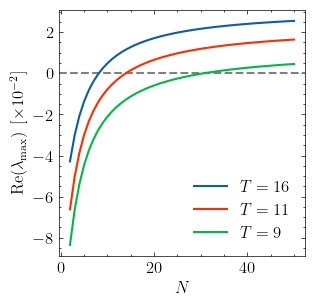

In [9]:
Ns = 2:50
# Parameters are (β, ρ, T)
# param_sets = [(2, 1/0.8, 16), (1, 1/5, 30)]
param_sets = [(2, 1, 16), (2, 1, 11), (2, 1, 9)]

fig, ax = plt.subplots()
ax.set(
    xlabel = L"N", ylabel = L"\operatorname{Re}(\lambda_\mathrm{max}) \: \left[\times 10^{-2}\right]",
    box_aspect = 1
)
ax.axhline(0.0, ls = "--", c = "gray")
for p in param_sets
    ax.plot(Ns, λ_max.(erlang_block_kernel_jacobian.(p..., Ns)) ./ 10^(-2),
            label = L"T = %$(p[end])")
end
ax.legend()
display(fig)

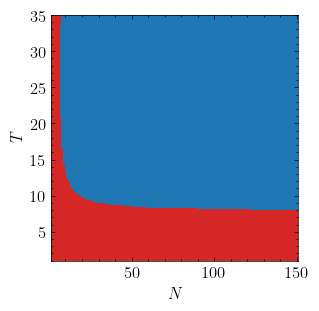

In [271]:
# Ns = 5:1:200
# Ts = 2:0.1:60
# β, ρ = 5, 1
Ns = 2:1:150
Ts = 1:0.1:35
β, ρ = 2, 1

# https://groups.google.com/g/julia-users/c/83Pfg9HGhGQ/m/9G_0wi-GBQAJ
# z = [λ_max(erlang_block_kernel_jacobian(β, ρ, T, N)) for T in Ts, N in Ns]
sign_change = (diff(sign.(z), dims = 1) .!= 0)[:, 1:end-1] + (diff(sign.(z), dims = 2) .!= 0)[1:end-1, :]

fig, ax = plt.subplots(figsize = (4, 3.2))
ax.set(box_aspect = 1, xlabel = L"N", ylabel = L"T")
# Heatmap
# hm_cmap = plt.cm.Blues.copy()
# hm_cmap.set_under("white")

# Arguments are name, red, green, blue codes. Tuples resemble (x, y0, y1), where
# x is input to colormap, y0 is end point of interpolation from last color and
# y1 is start point of interpolation to next color (y0 and y1 allow gaps in the
# colormap). Interpolation here between tab:red (x=0) and tab:blue (x=1).
hm_cmap = plt.ColorMap("cm", [(0.0, 0.8392, 0.8392), (1.0, 0.1215, 0.1215)], [(0.0, 0.1529, 0.1529), (1.0, 0.4666, 0.4666)], [(0.0, 0.1529, 0.1529), (1.0, 0.7058, 0.7058)], 2)

z_scaled = z ./ 10^(-2)
hm = ax.pcolormesh(Ns, Ts, z_scaled,
                   cmap = hm_cmap,
                   vmin = - maximum(z_scaled))
# Colorbar
# cbar = plt.colorbar(hm)
# cbar.ax.set(ylim = (-(maximum(z_scaled) - minimum(z_scaled))/1000, maximum(z_scaled)))
# cbar_labels = [label.get_text() for label in cbar.ax.get_yticklabels()]
# cbar_labels[2] = L"\leq 0.0"
# cbar.ax.set_yticklabels(cbar_labels)
# cbar.set_label(L"\operatorname{Re}(\lambda_\mathrm{max}) \: \left[\times 10^{-2}\right]", rotation=90)
# # Border -- TODO Wenn border fucked, vmin kleiner machen?
# border_cmap = plt.cm.Greys.copy()
# border_cmap.set_under(alpha = 0)
# ax.pcolormesh(Ns, Ts, sign_change, cmap=border_cmap, vmin = 10^(-10))
display(fig)

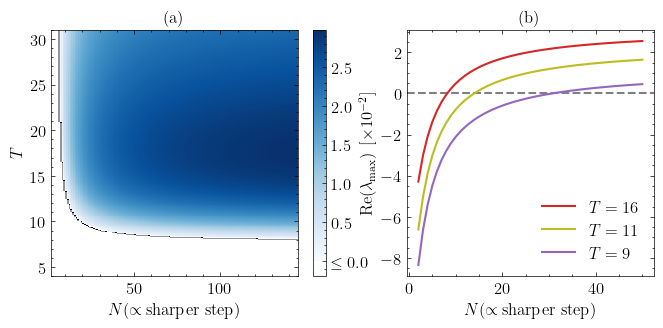

sys:1: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


In [131]:
## PLOT FOR POSTER ##


fig, (axl, axr) = plt.subplots(figsize=(8.2, 3.2), ncols = 2)
fig.subplots_adjust(wspace = 0.05)
axr.set(
    xlabel = L"N (\propto \text{sharper step})", ylabel = L"\operatorname{Re}(\lambda_\mathrm{max}) \: \left[\times 10^{-2}\right]",
    box_aspect = 1, title = "(b)"
)
Ns = 2:50
axr.axhline(0.0, ls = "--", c = "gray")
parameter_sets = [(2, 1, 16), (2, 1, 11), (2, 1, 9)] # Parameters are (β, ρ, T)
colors = ["tab:red", "tab:olive", "tab:purple"]
for (p, c) in zip(parameter_sets, colors)
    axr.plot(Ns, λ_max.(erlang_block_kernel_jacobian.(p..., Ns)) ./ 10^(-2),
            label = L"T = %$(p[end])", c = c)
end
axr.legend()


Ns = 2:1:150
Ts = 1:0.1:35
β, ρ = 2, 1

# https://groups.google.com/g/julia-users/c/83Pfg9HGhGQ/m/9G_0wi-GBQAJ
z = [λ_max(erlang_block_kernel_jacobian(β, ρ, T, N)) for T in Ts, N in Ns] # CALCULATION
sign_change = (diff(sign.(z), dims = 1) .!= 0)[:, 1:end-1] + (diff(sign.(z), dims = 2) .!= 0)[1:end-1, :]

axl.set(
    box_aspect = 1,
    xlabel = L"N (\propto \text{sharper step})", ylabel = L"T",
    ylim = (4, 31), xlim = (2, 145),
    title = "(a)"
)
# Heatmap
# Arguments are name, red, green, blue codes. Tuples resemble (x, y0, y1), where
# x is input to colormap, y0 is end point of interpolation from last color and
# y1 is start point of interpolation to next color (y0 and y1 allow gaps in the
# colormap). Interpolation here between tab:red (x=0) and tab:blue (x=1).
hm_cmap = plt.ColorMap("cm", [(0.0, 0.8392, 0.8392), (1.0, 0.1215, 0.1215)], [(0.0, 0.1529, 0.1529), (1.0, 0.4666, 0.4666)], [(0.0, 0.1529, 0.1529), (1.0, 0.7058, 0.7058)], 2)
z_scaled = z ./ 10^(-2)
hm = axl.pcolormesh(Ns, Ts, z_scaled,
                    cmap = hm_cmap, vmin = 0)
# Colorbar
cbar = plt.colorbar(hm)
cbar.ax.set(ylim = (-(maximum(z_scaled) - minimum(z_scaled))/1000, maximum(z_scaled)))
cbar_labels = [label.get_text() for label in cbar.ax.get_yticklabels()]
cbar_labels[2] = L"\leq 0.0"
cbar.ax.set_yticklabels(cbar_labels)
# cbar.set_label(L"\operatorname{Re}(\lambda_\mathrm{max}) \: \left[\times 10^{-2}\right]", rotation=90)
# Border -- TODO
border_cmap = plt.cm.Greys.copy()
border_cmap.set_under(alpha = 0)
axl.pcolormesh(Ns, Ts, sign_change, cmap=border_cmap, vmin = 10^(-100))
# fig.savefig("./img/eigenvalues.png", dpi = 500)
display(fig)

# Two step block delay

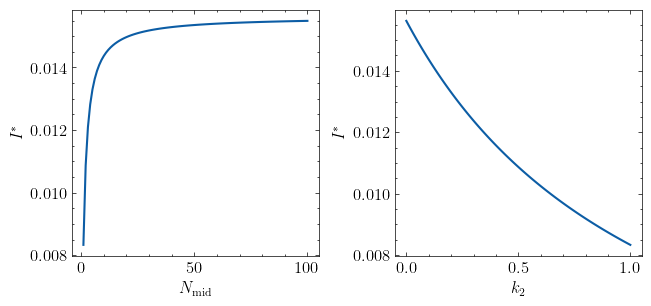

In [165]:
p = (β, ρ, T, N) = (0.8, 0.7, 20, 300)
fig, (axl, axr) = plt.subplots(figsize = (7.5, 3.2), ncols = 2)
k₁, k₂ = 1, 0.5
N_mids = [N/i for i in 1:100]
axl.set(xlabel = L"N_\mathrm{mid}", ylabel = L"I^*", box_aspect=1)
axl.plot(1:100, general_two_step_kernel_fp.(p..., N_mids, k₁, k₂))

p = (β, ρ, T, N) = (0.8, 0.7, 20, 300)
N_mid, k₁ = N/2, 1
k₂s = 0:0.01:1
axr.set(xlabel = L"k_2", ylabel = L"I^*", box_aspect=1)
axr.plot(k₂s, general_two_step_kernel_fp.(p..., N_mid, k₁, k₂s))
display(fig)

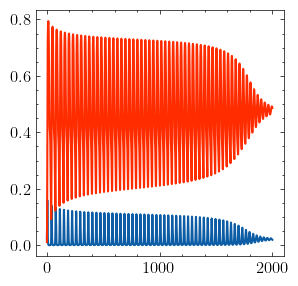

(erlang_two_step_kernel_fp(β, ρ, T), sol[1, end]) = (0.02127659574468085, 0.019049794291529337)


In [210]:
p = (β, ρ, T, N) = (2, 1, 30, 166)
I₀ = erlang_two_step_kernel_fp(β, ρ, T)
Rₘ₀ = ρ * T / N * I₀
t_max = 2000
# sol = solve_erlang_two_step_kernel(p..., I₀, t_max)
u₀ = fill(Rₘ₀ - Rₘ₀ * 10^(-0.01), N+1); u₀[1] = I₀ + 10^(-4)
sol = solve(
    ODEProblem(erlang_two_step_kernel!, u₀, (0.0, t_max), p),
    Tsit5(),
    # alg_hints = [:stiff],
    reltol = 1e-8
)

fig, ax = plt.subplots()
# ax.set(xlim=(0, 200))
ax.plot(sol.t, sol[1, :])
# @show minimum(sol[1, end-1000:end])
ax.plot(sol.t, erlang_two_step_kernel_R(sol, N))
display(fig)

# FP for cₘ(m) = m <= N/2 ? 1 : 0.5
@show (erlang_two_step_kernel_fp(β, ρ, T), sol[1, end]);

In [195]:
println(sol[1, 1])
println(sol[1, end])
println(erlang_two_step_kernel_R(sol, N)[1])
println(erlang_two_step_kernel_R(sol, N)[end])

0.02127659574468085
0.019264499714635577
0.0
0.4895114443360976


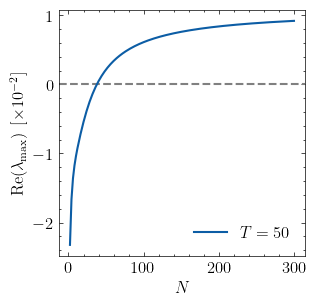

In [186]:
# FIXME: Max eigenvalue prediction correct for T = 50, but not for T = 30

# function test(
#         β::Real, ρ::Real, T::Real,
#         N::Integer,
#         I_endemic::Real
#     )
#     cₘ(m) = m <= N/2 ? 1 : 0.5
#     dim::Integer = N + 1
#     jac::Matrix{Float64} = diagm(0 => fill(-N/T, dim), -1 => fill(N/T, dim-1))
#     @show β * (1 - 2 * I_endemic - T * ρ * I_endemic * 3/4) - ρ
#     jac[1, 1] = β * (1 - 2 * I_endemic - T * ρ * I_endemic * 3/4) - ρ
#     @show [-β * I_endemic * cₘ(m) for m in 1:N]
#     jac[1, 2:end] = [-β * I_endemic * cₘ(m) for m in 1:N]
#     jac[2, 1] = ρ
#     return jac
# end

# p = (β, ρ, T) = (2, 1, 50)
# J = test(p..., 500, erlang_two_step_kernel_fp(p...))
# @show λ_max(J)


# Parameters are (β, ρ, T)
p = (β, ρ, T) = (2, 1, 50)

Ns = 2:2:300
fig, ax = plt.subplots()
ax.set(
    xlabel = L"N", ylabel = L"\operatorname{Re}(\lambda_\mathrm{max}) \: \left[\times 10^{-2}\right]",
    box_aspect = 1
)
ax.axhline(0.0, ls = "--", c = "gray")
ax.plot(Ns, λ_max.(erlang_two_step_kernel_jacobian.(p..., Ns)) ./ 10^(-2),
        label = L"T = %$(p[end])")
ax.legend()
# ax.grid(which="minor")
display(fig)

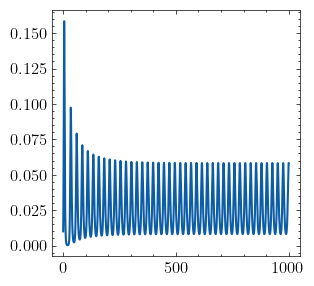

(gen_fp(β, ρ, T, k), sol[1, end]) = (0.02631578947368421, 0.0582543011670127)
λ_max(J) = 0.0045789025796969625


0.0045789025796969625

In [142]:
p = (β, ρ, T, N) = (2, 1, 30, 50)
k = 0.5
cₘ(m) = m <= N/2 ? 1 : k
I₀ = 0.01
t_max = 1000
sol = solve_erlang_superpos_kernel(p..., cₘ, I₀, t_max)

fig, ax = plt.subplots()
# ax.set(xlim=(0, 200))
ax.plot(sol.t, sol[1, :])
# @show minimum(sol[1, end-1000:end])
display(fig)

gen_fp(β, ρ, T, k) = (2*(β - ρ))/(β*((k + 1)*ρ*T + 2))
@show (gen_fp(β, ρ, T, k), sol[1, end]);

J = erlang_superpos_kernel_jacobian(p..., cₘ, gen_fp(β, ρ, T, k))
@show λ_max(J)